In [1]:
!unzip 134715_320111_bundle_archive.zip

Archive:  134715_320111_bundle_archive.zip
  inflating: IMDB Dataset.csv        


In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.6MB/s 


In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization

In [2]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [3]:
df=pd.read_csv("IMDB Dataset.csv")

In [4]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    
def preprocess_text(sen):
  # Removing html tags
  sentence = remove_tags(sen)

  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence


reviews = []
sentences = list(df['review'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [6]:
df['sentiment']= df['sentiment'].map({'positive':1,'negative':0})

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews, df['sentiment'], test_size=0.33, random_state=42)

In [8]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [9]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [11]:
train_input = bert_encode(X_train, tokenizer, max_len=100)
test_input = bert_encode(X_test, tokenizer, max_len=100)

In [12]:
model = build_model(bert_layer, max_len=100)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [13]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

In [14]:
train_history = model.fit(
    train_input, tf.convert_to_tensor(y_train, dtype=tf.float32),
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

model.save('model.h5')

Epoch 1/3
1675/1675 [==============================] - 3436s 2s/step - loss: 0.3184 - accuracy: 0.8575 - val_loss: 0.2745 - val_accuracy: 0.8813
Epoch 2/3
1675/1675 [==============================] - 3425s 2s/step - loss: 0.2078 - accuracy: 0.9168 - val_loss: 0.2799 - val_accuracy: 0.8858
Epoch 3/3
1675/1675 [==============================] - 3413s 2s/step - loss: 0.1065 - accuracy: 0.9638 - val_loss: 0.3426 - val_accuracy: 0.8804


In [15]:
y_pred= model.predict(test_input)

In [18]:
y_pred=y_pred.round().astype(int)

Accuracy on test set: 88.200%
F1-Score on test set: 0.880


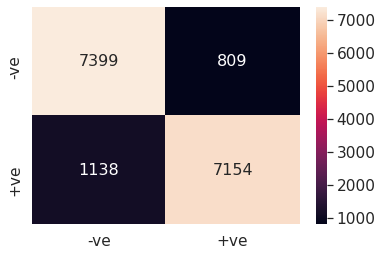

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import seaborn as sns
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
labels = ['-ve','+ve']
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',xticklabels=labels, yticklabels=labels)